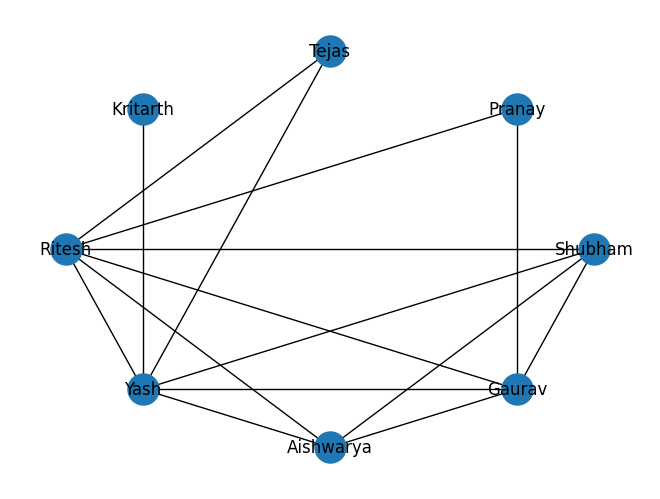

Compatibility Scores: 
Ritesh-->Gaurav : 44.44444444444444
Ritesh-->Yash : 33.33333333333333
Ritesh-->Shubham : 30.0
Ritesh-->Aishwarya : 25.0
Ritesh-->Pranay : 12.5
Ritesh-->Tejas : 12.5
nx.html


tensor([[-0.8501, -0.5575],
        [-0.7115, -0.6751],
        [-0.7384, -0.6498],
        [-0.7822, -0.6114],
        [-0.8021, -0.5949],
        [-0.8756, -0.5389],
        [-0.6257, -0.7655],
        [-0.7744, -0.6180]], grad_fn=<LogSoftmaxBackward0>)

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

from pyvis import network as net

# Read the CSV file
#df = pd.read_csv("R:/random_data.csv")
df = pd.read_csv("profile_dataNewest.csv")

# Main function to create GCN and perform forward pass
def gcn_main():
    # Initialize NetworkX graph and dictionaries
    G = nx.Graph()
    label = {}
    likes = {}
    search = {}
    '''for (user, category) in zip(df['first_name'], df['categories']):
      label[user]=user
      G.add_node(user)
      likes[user]=category'''

    # Create nodes in the graph
    for i, (user, category) in enumerate(zip(df['first_name'], df['categories'])):
        label[i] = user  # Use index as node label
        search[user] = i
        G.add_node(i,title=user , label=user,)
        likes[user] = category

    # Create edges based on common categories
    for u in range(len(label)):
        for v in range(len(label)):
            if u != v:
              categories1 = set(likes[label[u]].split(','))
              categories2 = set(likes[label[v]].split(','))
              common_categories = categories1.intersection(categories2)
              union_categories = categories1.union(categories2)
              similarity_score = float(len(common_categories)/len(union_categories))*100
              if common_categories:
                G.add_edge(u, v,weight=similarity_score)

    # Check if the graph has any edges
    if G.number_of_edges() == 0:
        print("Error: The graph has no edges.")
        return

    # Convert edges to a list of tuples
    edges = list(G.edges())

    # Create a sample data with node features (x) and edge indices
    x = torch.randn(len(label), 16)  # Random node features
    edge_index = torch.tensor(edges).t().contiguous()  # Edge indices
    data = Data(x=x, edge_index=edge_index)

    # Instantiate GCN model
    gcn_model = GCNModel(input_dim=16, hidden_dim=32, output_dim=2)

    # Forward pass
    gcn_output = gcn_model(data)

    # Visualize the graph
    visualize_graph(G, label,search)
    
    return gcn_output

def get_score(G,label,user1):
  user_score  = {}
  for user2 in label:
    if (user1 != user2) and (G.get_edge_data(user1,user2) is not None):
      user_score[user2]=G.get_edge_data(user1,user2)["weight"]
  print("Compatibility Scores: ")
  for user in (sorted(user_score.items(), key=lambda x:x[1], reverse=True)):
    print(f"{label[user1]}-->{label[user[0]]} :",user[1])

# GCN Model
class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return F.log_softmax(x, dim=1)

# Function to visualize the graph
def visualize_graph(G, label,search):
    pos = nx.shell_layout(G)
    nx.draw(G, pos, labels=label, with_labels=True, node_size=500)
    plt.draw()
    plt.show()
    user_name=input("Enter user name: ")
    get_score(G,label,search[user_name])
    nt = net.Network(notebook=True,cdn_resources='remote' ,height="900px", width="100%", bgcolor="#222222", font_color="white")
    nt.barnes_hut()
    nt.from_nx(G, default_node_size=100, show_edge_weights=True, edge_scaling=True)
    #nt.toggle_physics(True)
    #nt.show_buttons(filter_=['physics'])
    neighbor_map = nt.get_adj_list()
    # add neighbor data to node hover data
    for node in nt.nodes:
      node["title"] += " Neighbors: <br>" + " <br> ".join(str(neighbor_map[node["id"]]))
      node["value"] = len(neighbor_map[node["id"]])
      
    nt.prep_notebook()
    nt.show('nx.html')

gcn_main()


